In [38]:
import collections
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import community

In [39]:
#构造网络
def construct_graph(path):#输入初始文件的路径，构造一个有起点、终点、边权的网络
    G=collections.defaultdict(dict)#设置空白默认字典
    with open(path) as txt:
        for line in txt:
            vertices=line.strip().split() 
            # .strip()删除字符串line开头结尾处的空格 # .split()按照空格分隔
            # 返回一个列表，含有2个字符串元素
            v_i=int(vertices[0])
            v_j=int(vertices[1])
            w=np.ones(1)#如果是加权网络，w为权值
            G[v_i][v_j]=w
            G[v_j][v_i]=w
    return G


In [40]:
#给节点分配社团
class Vertex():
    def __init__(self, vid, cid, nodes, k_in=0):
    #每个节点具有属性：vid:节点编号；cid:社团编号；k_in:节点自环个数
        self._vid = vid
        self._cid = cid
        self._nodes = nodes   # 
        self._kin = k_in      # 节点内部的边的权重
   

In [41]:
#算法过程
class Louvain():
    def __init__(self, G): # 算法初始化
        self._G = G  # G是一个嵌套字典
        self._m = 0  # 边数量
        # 下面两个空字典存放信息
        self._cid_vertices = {}  # 需维护的关于社区的信息(社区编号,其中包含的结点编号的集合)
        self._vid_vertex = {}    # 需维护的关于节点的信息(节点编号，相应的Vertex实例)
        for vid in self._G.keys(): # self._G.keyds()字典的键值列表
            # 含vid得社区名为vid,社区用列表表示，必含有Vid
            self._cid_vertices[vid] = set([vid]) 
            
            # 对于顶点vid进行‘类初始化 class Vertex'
            self._vid_vertex[vid] = Vertex(vid, vid, set([vid]))
            
            # 求graph得边数量：对每个vid得邻居 neighbor ,如果neirbor>vid，则加1，避免(i,j)和（j,i）重复
            self._m += sum([1 for neighbor in self._G[vid].keys() if neighbor > vid])
            
    #第一阶段循环
    def first_stage(self):
        mod_inc = False  # 用于判断算法是否可终止
        visit_sequence = self._G.keys()  # 需要拜访得节点列表(所有节点)
        random.shuffle(list(visit_sequence)) # 转化为列表后并打算列表得排列顺序
        while True:
            can_stop = True  # 第一阶段是否可终止
            for v_vid in visit_sequence:
                # 随机选择第一个节点v_vid(随机体现在shuffle),
                # 其'属性_vid_vertex'是对节点实例化后，令'属性_cid'(即节点所在得社区编号)赋值
                v_cid = self._vid_vertex[v_vid]._cid
                
                # 假设G={1102:{1221:2,1321:3},1221:{1102:2,1456:4}}
                # G[1102].values()=[2,3] ，sum求和后表示含节点1102得边数目  # kin初始化为0
                # k_v表示节点v_vid的所有边权重之和
                k_v = sum(self._G[v_vid].values()) + self._vid_vertex[v_vid]._kin
                
                cid_Q = {}
                # G[1102].keys()=[1221,1321],即节点1102得邻居
                for w_vid in self._G[v_vid].keys():
                    w_cid = self._vid_vertex[w_vid]._cid  # 邻居所在得社区编号
                    if w_cid in cid_Q:
                        continue    # 若邻居w_ci的社区在 字典cid_Q中则不操作
                    else:   
                        '''
                        _cid_vertices[w_cid]：表示编号为w_cid的社区，k是社区w_cid的节点
                         G[k].values()：是权重值
                         sum(self._G[k].values()) ：节点k的所有出边的边总数
                         _vid_vertex[k]._kin： 表示对节点k的‘属性k_in’(自环边)
                         sum([k的所有边(出边+自环边)])：社区w_cid的内部边+连接边 
                        '''
                        tot = sum(
                            [sum(self._G[k].values()) + self._vid_vertex[k]._kin \
                            for k in self._cid_vertices[w_cid]])
                        '''
                         v_vid节点的邻居w_vid的
                         v_vid的社区编号v_cid；w_vid的社区编号为w_cid
                         如果v_vid与其邻居w_vid的社区编号相同，则移除v_vid后计算社团的边权重之和
                         '''
                        if w_cid == v_cid:
                            tot -= k_v
                        
                        '''
                        _cid_vertices[w_cid]:表示社区编号为w_cid的社区，k是社区内的节点
                        G[v_vid].items():G[1102].items()=dict_items([(1221, 2), (1321, 3)])
                        k_v_in:当遍历节点v_vid的邻居时判断k如果是w_cid社区内的节点，则求权重之和
                        '''                                             
                        k_v_in = sum([v for k, v in self._G[v_vid].items() if k in self._cid_vertices[w_cid]])
                        
                        delta_Q = k_v_in - k_v * tot / self._m  # 由于只需要知道delta_Q的正负，所以少乘了1/(2*self._m)
                        cid_Q[w_cid] = delta_Q

                cid, max_delta_Q = sorted(cid_Q.items(), key=lambda item: item[1], reverse=True)[0]
                '''
                参量 key：表示排序的关键字
                参量 reverse=True:表示逆序，从大到小排列
                lambda item :item[1]: item 是一个sorted的变量(即为字典的items迭代量)，形式为（key,value）的二元组
                                      item[1],即表示上述二元组的value
                整体含义为：按照字典中的value,从大到小排序
                '''
                if max_delta_Q > 0.0 and cid != v_cid:
                    self._vid_vertex[v_vid]._cid = cid
                    self._cid_vertices[cid].add(v_vid)
                    self._cid_vertices[v_cid].remove(v_vid)
                    can_stop = False
                    mod_inc = True
            if can_stop:
                break
        return mod_inc            

    #构造新网络
    def second_stage(self):
        # 搭建两个新字典，用于存放新社团和新节点
        cid_vertices = {}
        vid_vertex = {}
        '''
        _cid_vertices:字典，键为社区编号，值为对应社区中的节点构成的列表
        _cid_vertices={1102:[1102,1321],1456:[1221,1456],1421:[1421],1321:[],1221:[]}
         '''
        for cid, vertices in self._cid_vertices.items():
            if len(vertices) == 0:
                continue   # 如果是空社区跳过
            # 将非空社团的作为新节点，新节点编号为社区编号，社区编号不变，节点设置为空集
            new_vertex = Vertex(cid, cid, set()) 
            # 更新新节点的各种属性
            for vid in vertices:
                # 新节点的_nodes属性中增加社团中的节点，update类似于append
                new_vertex._nodes.update(self._vid_vertex[vid]._nodes)
                # 新节点的_kin属性，是包含社团中节点的所有自环
                new_vertex._kin += self._vid_vertex[vid]._kin
                # 新节点的_kin属性，是包含社团中节点的内边的权重之和(边不重复)
                for k, v in self._G[vid].items():
                    if k in vertices:
                        new_vertex._kin += v / 2.0
            # 前面部分搭建完新节点属性后，对每个新节点作为一个新的社团，且搭建新节点存放         
            cid_vertices[cid] = set([cid])
            vid_vertex[cid] = new_vertex
        
        # 构建新网络
        G = collections.defaultdict(dict)
        # 在原社团字典中，搭建新网络的连边，
        # 节点1(cid1)，节点2(cid2)都是是原社团中的社团编号
        for cid1, vertices1 in self._cid_vertices.items():
            if len(vertices1) == 0:
                continue # 如果社团为空，则跳过
            for cid2, vertices2 in self._cid_vertices.items():
                if cid2 <= cid1 or len(vertices2) == 0:                 
                    continue # 如果cid2与cid1相同或者cid2社团为空，则跳过，<是为避免重复
                '''
                新节点边的初始权重为0，取社团cid1的节点vid,再取vid的邻居wid及权重v,
                判断wid如果在社团cid2中，则新边权重增加v
                '''
                edge_weight = 0.0
                for vid in vertices1:
                    for wid, v in self._G[vid].items():
                        if wid in vertices2:
                            edge_weight += v
                # 如果新边权重不为0，则将这条新边记录到图G中
                if edge_weight != 0:
                    G[cid1][cid2] = edge_weight
                    G[cid2][cid1] = edge_weight
        # 新构建的节点、新社团划分、新图G更新
        self._cid_vertices = cid_vertices
        self._vid_vertex = vid_vertex
        self._G = G

    #新网络获得社团
    def get_communities(self):
        communities = []
        # vertices是社团中的节点列表
        for vertices in self._cid_vertices.values():
            # 如果社团不为空，则用vid遍历社团中的节点，将每个节点中node属性放入集合C中，再将集合放入列表
            if len(vertices) != 0:
                c = set()
                for vid in vertices:
                    c.update(self._vid_vertex[vid]._nodes)
                communities.append(c)
        return communities

    #这两个过程进行循环
    def execute(self):
        iter_time = 1 # 迭代次数
        while True:
            iter_time += 1
            mod_inc = self.first_stage() # 第一阶段执行，
            if mod_inc:  # 若返回mod_inc=True，则执行第二阶段
                self.second_stage()
            else:        # 否则，跳出循环
                break
        return self.get_communities() # 返回得到的社团


In [42]:
#主函数进行调用
if __name__ == '__main__':
    G = construct_graph('/content/drive/MyDrive/Colab Notebooks/Facebook/facebook.txt')
    algorithm = Louvain(G)
    communities = algorithm.execute()
    # 按照社区大小从大到小排序输出
    communities = sorted(communities, key=lambda b: -len(b)) # 按社区大小排序
    count = 0
    result=list(range(0,len(G)))
    print(result)
    for communitie in communities:
        count += 1
        print("社区", count, " ", communitie)#输出结果
        for i in communitie:
            result[i]=count



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

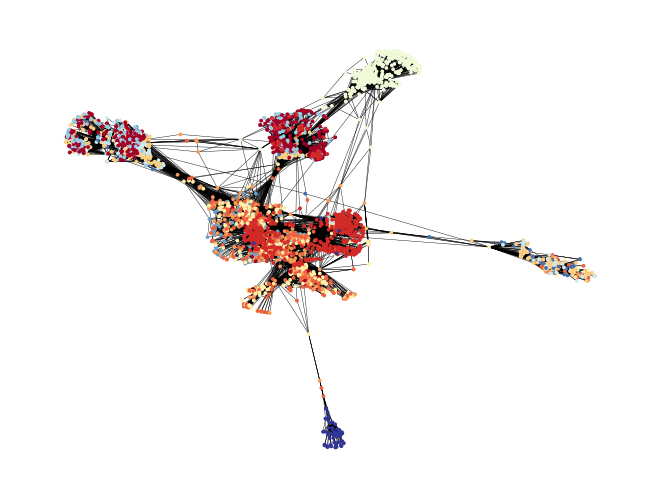

In [53]:
#社区划分结果可视化           
Graph=nx.to_networkx_graph(G)
nx.draw_spring(Graph, cmap=plt.cm.RdYlBu, node_color = result, node_size=3, with_labels=False, width=0.3)
plt.show()